<a href="https://colab.research.google.com/github/Abubakrhegazi/Arabic-Grammar-AutoCorrection/blob/main/Arabic_GED_GEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
from google.colab import drive
drive.mount('/content/drive')

# file_path = '/content/drive/My Drive/grammar/QALB-Train2014.m2'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
#functions dictionary
def smart_open(fname, mode = 'r'):
    if fname.endswith('.gz'):
        import gzip
        # Using max compression (9) by default seems to be slow.
        # Let's try using the fastest.
        return gzip.open(fname, mode, 1)
    else:
        return open(fname, mode)

import sys
from getopt import getopt

def load_annotation(gold_file):
    source_sentences = []
    gold_edits = []
    fgold = smart_open(gold_file, 'r')
    puffer = fgold.read()
    fgold.close()

    for item in paragraphs(puffer.splitlines(True)):
        item = item.splitlines(False)
        sentence = [line[2:].strip() for line in item if line.startswith('S ')]
        assert sentence != []
        annotations = {}

        for line in item[1:]:
            if line.startswith('I ') or line.startswith('S '):
                continue
            assert line.startswith('A ')
            line = line[2:]
            fields = line.split('|||')

            start_offset = int(fields[0].split()[0])
            end_offset = int(fields[0].split()[1])
            etype = fields[1]  # Error type

            if etype == 'noop':
                start_offset = -1
                end_offset = -1

            corrections = [c.strip() if c != '-NONE-' else '' for c in fields[2].split('||')]
            original = ' '.join(' '.join(sentence).split()[start_offset:end_offset])

            if len(fields) > 4:
                annotator = int(fields[5]) if len(fields) > 5 else 0
            else:
                annotator = 0

            if annotator not in annotations.keys():
                annotations[annotator] = []

            # Include error type in the tuple
            annotations[annotator].append((start_offset, end_offset, original, corrections, etype))

        tok_offset = 0
        for this_sentence in sentence:
            tok_offset += len(this_sentence.split())
            source_sentences.append(this_sentence)
            this_edits = {}

            for annotator, annotation in annotations.items():
                this_edits[annotator] = [edit for edit in annotation
                                       if edit[0] <= tok_offset and edit[1] <= tok_offset
                                       and edit[0] >= 0 and edit[1] >= 0]

            if len(this_edits) == 0:
                this_edits[0] = []
            gold_edits.append(this_edits)

    return (source_sentences, gold_edits)
def paragraphs(lines, is_separator=lambda x : x == '\n', joiner=''.join):
    paragraph = []
    for line in lines:
        if is_separator(line):
            if paragraph:
                yield joiner(paragraph)
                paragraph = []
        else:
            paragraph.append(line)
    if paragraph:
        yield joiner(paragraph)

In [69]:
def process_data_with_error_types():
    """
    Complete pipeline to extract input, corrections, and error types
    """
    # Load data with error types
    sentences, operations = load_annotation_with_error_type('/content/QALB-Train2014.m2')

    # Extract all corrections with error types
    all_inputs = []
    all_corrections = []
    all_error_types = []

    for i in range(len(operations)):
        if operations[i]:  # Check if there are annotations
            # Get first annotator's data (annotator 0)
            annotator_data = operations[i].get(0, [])

            if annotator_data:
                inputs, corrections, error_types = extract_with_error_type(annotator_data)
                all_inputs.extend(inputs)
                all_corrections.extend(corrections)
                all_error_types.extend(error_types)

    return all_inputs, all_corrections, all_error_types

In [70]:
def analyze_error_types(error_corrections):
    """
    Analyze distribution of error types
    """
    from collections import Counter

    error_type_counts = Counter([ec.error_type for ec in error_corrections])

    print("Error Type Distribution:")
    print("-" * 30)
    for error_type, count in error_type_counts.most_common():
        print(f"{error_type}: {count}")

    return error_type_counts

In [71]:
m2_list_sentence=[]
m2_list_operation=[]

m2_list_sentence.append(load_annotation('/content/drive/MyDrive/Grammar/QALB-Train2014.m2')[0])
m2_list_operation.append(load_annotation('/content/drive/MyDrive/Grammar/QALB-Test2014.m2')[1])


In [72]:
# For extracting actual corrections

def extract(operation):
  input_text = []
  corrections = []
  error_types = []

  for i in range(len(operation)):
      if (operation[i][0] != operation[i][1]):  # Only include actual edits
          input_text.append(operation[i][2])      # Original text
          corrections.append(operation[i][3][0])  # First correction
          error_types.append(operation[i][4])     # Error type

  return (input_text, corrections, error_types)

In [73]:
def make_tokens(list):
  tokens =[]
  for s in list:
      for i in s:
          tokens.append(i.split(' '))
  return tokens


In [74]:
tokens =[]
i=0
for i in m2_list_sentence:
    tokens = make_tokens(m2_list_sentence)
# print(tokens[0])
# len(tokens)

In [75]:
print("len(tokens):", len(tokens))
print("len(m2_list_operation[0]):", len(m2_list_operation[0]))


len(tokens): 19411
len(m2_list_operation[0]): 968


In [76]:
list_correction = []
list_input = []
list_error = []
for i in range(len(m2_list_operation[0])):  # ✅ Use the shorter list
    edits = m2_list_operation[0][i][0]
    input_, correction, error = extract(edits)
    list_input.append(input_)
    list_correction.append(correction)
    list_error.append(error)


In [77]:
for i in range(5):  # test like df.head f pandas
    print(f"Input {i}:", list_input[i])
    print(f"Correction {i}:", list_correction[i])
    print()

Input 0: ['لا زال', 'الشبيحه', 'ان', 'ارواح', 'اقل', 'كلفه', 'اذا', 'المعادله', 'المهينه', 'ان', 'هبه', 'قويه', 'واحده', 'وياخذو', 'العصابه', 'عنوه', '،', 'اننا', 'اكثر', 'اربعين', 'عام']
Correction 0: ['لازال', 'الشبيحة', 'أن', 'أرواح', 'أقل', 'كلفة', 'إذا', 'المعادلة', 'المهينة', 'أن', 'هبة', 'قوية', 'واحدة', 'ويأخذوا', 'العصابة', 'عنوة', '.', 'إننا', 'أكثر', 'أربعين', 'عاما']

Input 1: ['امريكان', 'و يا', 'اذنابهم', 'ان', 'امن', 'تستطيعوا', 'لان', 'و سترون', 'الاسد', 'الاكتاف', 'تهو', 'الامويين']
Correction 1: ['أمريكان', 'ويا', 'أذنابهم', 'أن', 'أمن', 'تستطيعون', 'لأن', 'وسترون', 'الأسد', 'الأكتاف', 'تهز', 'الأمويين']

Input 2: ['إعتقاد']
Correction 2: ['اعتقاد']

Input 3: ['راينا', 'اماكن', 'و للتقطيع', 'بالتاكيد', 'او', 'او', 'ابيا', 'واسفاه', 'و ساند', 'اذيالها']
Correction 3: ['رأينا', 'أماكن', 'وللتقطيع', 'بالتأكيد', 'أو', 'أو', 'أبيا', 'وأسفاه', 'وساند', 'أذيالها']

Input 4: ['الى', 'مشاركه', 'انت', 'الاحرار', 'لايخافون', 'لانهم', 'الانفس', 'البريئه', 'اما', 'الارانب', 'لانه'

In [78]:
# Join tokens back into strings
inputs = [' '.join(words) for words in list_input]
corrections = [' '.join(words) for words in list_correction]


In [79]:
import pandas as pd

df = pd.DataFrame({
    'input': [' '.join(x) for x in list_input],
    'correction': [' '.join(y) for y in list_correction]
})
df.to_csv('grammar_corrections.csv', index=False)
df.head(10)

,input,correction
0,لا زال الشبيحه ان ارواح اقل كلفه اذا المعادله ...,لازال الشبيحة أن أرواح أقل كلفة إذا المعادلة ا...
1,امريكان و يا اذنابهم ان امن تستطيعوا لان و ستر...,أمريكان ويا أذنابهم أن أمن تستطيعون لأن وسترون...
2,إعتقاد,اعتقاد
3,راينا اماكن و للتقطيع بالتاكيد او او ابيا واسف...,رأينا أماكن وللتقطيع بالتأكيد أو أو أبيا وأسفا...
4,الى مشاركه انت الاحرار لايخافون لانهم الانفس ا...,إلى مشاركة أنت الأحرار لا يخافون لأنهم الأنفس ...
5,,
6,اخر ايامك احرار الا ان تكبرو ان اتي احرار صلو ...,آخر أيامك أحرار إلا أن تكبروا إن أتى أحرار صلو...
7,"اثبت انه اسد و في , اوقف الاسرائيلي سوري فماكا...",أثبت أنه أسد وفي ، أوقف الإسرائيلي سورية فما ك...
8,الاطفال ارهابيون لانهم الامة الامة الى اخر الا...,الأطفال إرهابيون لأنهم الأمة الأمة إلى آخر ألا...
9,احبكم ارض امام اجندة إحتلال وامام انا إبن إبن,أحبكم أرض أمام أجندة احتلال وأمام أنا ابن ابن


In [80]:
# Check for nulls in the DataFrame
print(df.isnull().sum())

input         0
correction    0
dtype: int64


In [81]:
# Preprocessing regular expressions
import re
def process(sent):
    # sent=sent.lower()
    # sent=re.sub(r'[^0-9]','',sent)

    #sent=sent.replace(' ','\n')
    sent=sent.replace('ـ','')
    sent=sent.replace('-','')
    sent=sent.replace(')','')
    sent=sent.replace('(','')
    sent=sent.replace('*','')
    sent=sent.replace(',','')
    sent=sent.replace('/','')
    sent=sent.replace('&','')
    sent=sent.replace('amp','')
    sent=sent.replace('_','')
    sent=sent.replace('ّ','')
    sent=sent.replace('ً','')
    sent=sent.replace('%','')
    sent=sent.replace(';','')
    sent=sent.replace('ِ','')
    sent=sent.replace('@','')
    sent=sent.replace('ګ','')
    sent=sent.replace( 'ٍ','')
    sent=sent.replace('٪','')
    sent=sent.replace('ٱ','')
    sent=sent.replace('ُ','')
    sent=sent.replace(':','')
    sent=sent.replace('؛','')
    sent=sent.replace('[','')
    sent=sent.replace(']','')
    sent=sent.replace('=','')
    sent=sent.replace('^','')
    sent=sent.replace('?','')
    sent=sent.replace('{','')
    sent=sent.replace('}','')
    sent=sent.replace('g','')
    sent=sent.replace('t','')
    sent=sent.replace('a','')
    sent=sent.replace('b','')
    sent=sent.replace('c','')
    sent=sent.replace('d','')
    sent=sent.replace('s','')
    sent=sent.replace('f','')
    sent=sent.replace('h','')
    sent=sent.replace('j','')
    sent=sent.replace('k','')
    sent=sent.replace('l','')
    sent=sent.replace('q','')
    sent=sent.replace('t','')
    sent=sent.replace('a','')
    sent=sent.replace('b','')
    sent=sent.replace('c','')
    sent=sent.replace('d','')
    sent=sent.replace('s','')
    sent=sent.replace('f','')
    sent=sent.replace('h','')
    sent=sent.replace('j','')
    sent=sent.replace('k','')
    sent=sent.replace('l','')
    sent=sent.replace('q','')
    sent=sent.replace('w','')
    sent=sent.replace('e','')
    sent=sent.replace('r','')
    sent=sent.replace('y','')
    sent=sent.replace('u','')
    sent=sent.replace('i','')
    sent=sent.replace('o','')
    sent=sent.replace('p','')
    sent=sent.replace('z','')
    sent=sent.replace('x','')
    sent=sent.replace('v','')
    sent=sent.replace('n','')
    sent=sent.replace('m','')
    sent=sent.replace('\\','')
    sent=sent.replace('$','')
    sent=sent.replace('`','')
    sent=sent.replace('~','')
    sent=sent.replace('|','')
    sent=sent.replace('گ','')
    sent=sent.replace("'",'')
    # sent=sent.replace('ُ','')
    # sent=sent.replace(':','')
    # sent=sent.replace('ُ','')
    # sent=sent.replace(':','')
    # sent=sent.replace('ُ','')
    # sent=sent.replace(':','')
    # sent=sent.replace('ُ','')
    # sent=sent.replace(':','')
    # sent=sent.replace('ُ','')
    # sent=sent.replace(':','')

    return sent

In [82]:
# df['processed_input'] = df['input'].apply(process)
# df['processed_correction'] = df['correction'].apply(process)
# df.head()

In [83]:
import re

def standerdize(text):
    # Define characters to remove
    text = re.sub(r'[a-zA-Zـًٍُِّٱ٪\*\,/\\:\؛@\$&_\^~\|\'"=\?\{\}\[\]\(\)`]', '', text)
    return text.strip()


In [84]:
raw_text = "ـأحبكم @أرض أمام أجندة amp إحتلال، وأمام أنا إبن إبنً!"

print(raw_text)
cleaned = standerdize(raw_text)
print(cleaned)
proc = process(raw_text)
print(proc)

ـأحبكم @أرض أمام أجندة amp إحتلال، وأمام أنا إبن إبنً!
أحبكم أرض أمام أجندة  إحتلال، وأمام أنا إبن إبن!
أحبكم أرض أمام أجندة  إحتلال، وأمام أنا إبن إبن!


In [85]:
df.head()

,input,correction
0,لا زال الشبيحه ان ارواح اقل كلفه اذا المعادله ...,لازال الشبيحة أن أرواح أقل كلفة إذا المعادلة ا...
1,امريكان و يا اذنابهم ان امن تستطيعوا لان و ستر...,أمريكان ويا أذنابهم أن أمن تستطيعون لأن وسترون...
2,إعتقاد,اعتقاد
3,راينا اماكن و للتقطيع بالتاكيد او او ابيا واسف...,رأينا أماكن وللتقطيع بالتأكيد أو أو أبيا وأسفا...
4,الى مشاركه انت الاحرار لايخافون لانهم الانفس ا...,إلى مشاركة أنت الأحرار لا يخافون لأنهم الأنفس ...


In [86]:
df['input'] = df['input'].apply(standerdize)
df['correction_new'] = df['correction'].apply(standerdize)
df['correction_old'] = df['correction'].apply(process)
df.head(20)

,input,correction,correction_new,correction_old
0,لا زال الشبيحه ان ارواح اقل كلفه اذا المعادله ...,لازال الشبيحة أن أرواح أقل كلفة إذا المعادلة ا...,لازال الشبيحة أن أرواح أقل كلفة إذا المعادلة ا...,لازال الشبيحة أن أرواح أقل كلفة إذا المعادلة ا...
1,امريكان و يا اذنابهم ان امن تستطيعوا لان و ستر...,أمريكان ويا أذنابهم أن أمن تستطيعون لأن وسترون...,أمريكان ويا أذنابهم أن أمن تستطيعون لأن وسترون...,أمريكان ويا أذنابهم أن أمن تستطيعون لأن وسترون...
2,إعتقاد,اعتقاد,اعتقاد,اعتقاد
3,راينا اماكن و للتقطيع بالتاكيد او او ابيا واسف...,رأينا أماكن وللتقطيع بالتأكيد أو أو أبيا وأسفا...,رأينا أماكن وللتقطيع بالتأكيد أو أو أبيا وأسفا...,رأينا أماكن وللتقطيع بالتأكيد أو أو أبيا وأسفا...
4,الى مشاركه انت الاحرار لايخافون لانهم الانفس ا...,إلى مشاركة أنت الأحرار لا يخافون لأنهم الأنفس ...,إلى مشاركة أنت الأحرار لا يخافون لأنهم الأنفس ...,إلى مشاركة أنت الأحرار لا يخافون لأنهم الأنفس ...
5,,,,
6,اخر ايامك احرار الا ان تكبرو ان اتي احرار صلو ...,آخر أيامك أحرار إلا أن تكبروا إن أتى أحرار صلو...,آخر أيامك أحرار إلا أن تكبروا إن أتى أحرار صلو...,آخر أيامك أحرار إلا أن تكبروا إن أتى أحرار صلو...
7,اثبت انه اسد و في اوقف الاسرائيلي سوري فماكان...,أثبت أنه أسد وفي ، أوقف الإسرائيلي سورية فما ك...,أثبت أنه أسد وفي ، أوقف الإسرائيلي سورية فما ك...,أثبت أنه أسد وفي ، أوقف الإسرائيلي سورية فما ك...
8,الاطفال ارهابيون لانهم الامة الامة الى اخر الا...,الأطفال إرهابيون لأنهم الأمة الأمة إلى آخر ألا...,الأطفال إرهابيون لأنهم الأمة الأمة إلى آخر ألا...,الأطفال إرهابيون لأنهم الأمة الأمة إلى آخر ألا...
9,احبكم ارض امام اجندة إحتلال وامام انا إبن إبن,أحبكم أرض أمام أجندة احتلال وأمام أنا ابن ابن,أحبكم أرض أمام أجندة احتلال وأمام أنا ابن ابن,أحبكم أرض أمام أجندة احتلال وأمام أنا ابن ابن


In [87]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1lnut4PCmo2FkE1K3jGRtKq8H7DMN7OxyhFula4aX5tE/edit#gid=0


In [88]:
# Find rows where 'input' column only contains whitespace
rows_with_only_space = df[df['input'].str.match(r'^\s*$')]

# Print the rows that match the condition
print("Rows with only whitespace in 'input' column:")
rows_with_only_space

Rows with only whitespace in 'input' column:


,input,correction,correction_new,correction_old
5,,,,
25,,,,
79,,,,
95,,,,
241,,,,
336,,,,
365,,,,
455,,،,،,،
494,,,,
594,,,,


In [89]:
# Drop rows where 'input' column only contains whitespace
df = df[~df['input'].str.match(r'^\s*$')]
print("\nDataFrame after dropping rows with only whitespace in 'input' column:")
df.head(10)


DataFrame after dropping rows with only whitespace in 'input' column:


,input,correction,correction_new,correction_old
0,لا زال الشبيحه ان ارواح اقل كلفه اذا المعادله ...,لازال الشبيحة أن أرواح أقل كلفة إذا المعادلة ا...,لازال الشبيحة أن أرواح أقل كلفة إذا المعادلة ا...,لازال الشبيحة أن أرواح أقل كلفة إذا المعادلة ا...
1,امريكان و يا اذنابهم ان امن تستطيعوا لان و ستر...,أمريكان ويا أذنابهم أن أمن تستطيعون لأن وسترون...,أمريكان ويا أذنابهم أن أمن تستطيعون لأن وسترون...,أمريكان ويا أذنابهم أن أمن تستطيعون لأن وسترون...
2,إعتقاد,اعتقاد,اعتقاد,اعتقاد
3,راينا اماكن و للتقطيع بالتاكيد او او ابيا واسف...,رأينا أماكن وللتقطيع بالتأكيد أو أو أبيا وأسفا...,رأينا أماكن وللتقطيع بالتأكيد أو أو أبيا وأسفا...,رأينا أماكن وللتقطيع بالتأكيد أو أو أبيا وأسفا...
4,الى مشاركه انت الاحرار لايخافون لانهم الانفس ا...,إلى مشاركة أنت الأحرار لا يخافون لأنهم الأنفس ...,إلى مشاركة أنت الأحرار لا يخافون لأنهم الأنفس ...,إلى مشاركة أنت الأحرار لا يخافون لأنهم الأنفس ...
6,اخر ايامك احرار الا ان تكبرو ان اتي احرار صلو ...,آخر أيامك أحرار إلا أن تكبروا إن أتى أحرار صلو...,آخر أيامك أحرار إلا أن تكبروا إن أتى أحرار صلو...,آخر أيامك أحرار إلا أن تكبروا إن أتى أحرار صلو...
7,اثبت انه اسد و في اوقف الاسرائيلي سوري فماكان...,أثبت أنه أسد وفي ، أوقف الإسرائيلي سورية فما ك...,أثبت أنه أسد وفي ، أوقف الإسرائيلي سورية فما ك...,أثبت أنه أسد وفي ، أوقف الإسرائيلي سورية فما ك...
8,الاطفال ارهابيون لانهم الامة الامة الى اخر الا...,الأطفال إرهابيون لأنهم الأمة الأمة إلى آخر ألا...,الأطفال إرهابيون لأنهم الأمة الأمة إلى آخر ألا...,الأطفال إرهابيون لأنهم الأمة الأمة إلى آخر ألا...
9,احبكم ارض امام اجندة إحتلال وامام انا إبن إبن,أحبكم أرض أمام أجندة احتلال وأمام أنا ابن ابن,أحبكم أرض أمام أجندة احتلال وأمام أنا ابن ابن,أحبكم أرض أمام أجندة احتلال وأمام أنا ابن ابن
10,؟ اوجاعا و مصائب و تقتلون و تسرقون و تعذبون و ...,، أوجاعا ومصائب وتقتلون وتسرقون وتعذبون وتكذبو...,، أوجاعا ومصائب وتقتلون وتسرقون وتعذبون وتكذبو...,، أوجاعا ومصائب وتقتلون وتسرقون وتعذبون وتكذبو...


In [90]:
df['correction'] = df['correction'].apply(standerdize)

<ipython-input-90-f730931d1ca6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['correction'] = df['correction'].apply(standerdize)


In [91]:
df = df.drop(columns=['correction_old', 'correction_new'])
df.head(10)

,input,correction
0,لا زال الشبيحه ان ارواح اقل كلفه اذا المعادله ...,لازال الشبيحة أن أرواح أقل كلفة إذا المعادلة ا...
1,امريكان و يا اذنابهم ان امن تستطيعوا لان و ستر...,أمريكان ويا أذنابهم أن أمن تستطيعون لأن وسترون...
2,إعتقاد,اعتقاد
3,راينا اماكن و للتقطيع بالتاكيد او او ابيا واسف...,رأينا أماكن وللتقطيع بالتأكيد أو أو أبيا وأسفا...
4,الى مشاركه انت الاحرار لايخافون لانهم الانفس ا...,إلى مشاركة أنت الأحرار لا يخافون لأنهم الأنفس ...
6,اخر ايامك احرار الا ان تكبرو ان اتي احرار صلو ...,آخر أيامك أحرار إلا أن تكبروا إن أتى أحرار صلو...
7,اثبت انه اسد و في اوقف الاسرائيلي سوري فماكان...,أثبت أنه أسد وفي ، أوقف الإسرائيلي سورية فما ك...
8,الاطفال ارهابيون لانهم الامة الامة الى اخر الا...,الأطفال إرهابيون لأنهم الأمة الأمة إلى آخر ألا...
9,احبكم ارض امام اجندة إحتلال وامام انا إبن إبن,أحبكم أرض أمام أجندة احتلال وأمام أنا ابن ابن
10,؟ اوجاعا و مصائب و تقتلون و تسرقون و تعذبون و ...,، أوجاعا ومصائب وتقتلون وتسرقون وتعذبون وتكذبو...


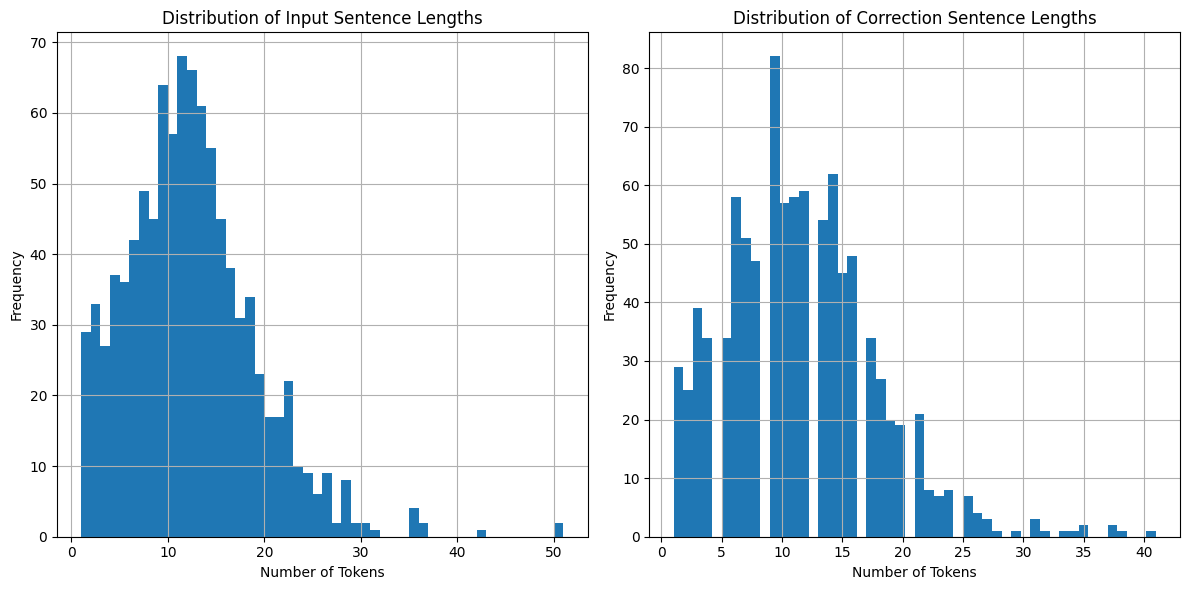


Input Sentence Length Statistics:
count    954.000000
mean      11.907757
std        6.719994
min        1.000000
25%        7.000000
50%       11.000000
75%       16.000000
max       51.000000
Name: input_length, dtype: float64

Correction Sentence Length Statistics:
count    954.000000
mean      11.400419
std        6.249368
min        1.000000
25%        7.000000
50%       11.000000
75%       15.000000
max       41.000000
Name: correction_length, dtype: float64


In [92]:
# prompt: make a chart to plot the senetence lengths

import matplotlib.pyplot as plt

# Calculate sentence lengths
df['input_length'] = df['input'].apply(lambda x: len(x.split()))
df['correction_length'] = df['correction'].apply(lambda x: len(x.split()))

# Plot histograms of sentence lengths
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['input_length'].hist(bins=50)
plt.title('Distribution of Input Sentence Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df['correction_length'].hist(bins=50)
plt.title('Distribution of Correction Sentence Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Optionally, you can print some descriptive statistics
print("\nInput Sentence Length Statistics:")
print(df['input_length'].describe())

print("\nCorrection Sentence Length Statistics:")
print(df['correction_length'].describe())

In [93]:
df.head(10)

,input,correction,input_length,correction_length
0,لا زال الشبيحه ان ارواح اقل كلفه اذا المعادله ...,لازال الشبيحة أن أرواح أقل كلفة إذا المعادلة ا...,22,21
1,امريكان و يا اذنابهم ان امن تستطيعوا لان و ستر...,أمريكان ويا أذنابهم أن أمن تستطيعون لأن وسترون...,14,12
2,إعتقاد,اعتقاد,1,1
3,راينا اماكن و للتقطيع بالتاكيد او او ابيا واسف...,رأينا أماكن وللتقطيع بالتأكيد أو أو أبيا وأسفا...,12,10
4,الى مشاركه انت الاحرار لايخافون لانهم الانفس ا...,إلى مشاركة أنت الأحرار لا يخافون لأنهم الأنفس ...,16,17
6,اخر ايامك احرار الا ان تكبرو ان اتي احرار صلو ...,آخر أيامك أحرار إلا أن تكبروا إن أتى أحرار صلو...,16,16
7,اثبت انه اسد و في اوقف الاسرائيلي سوري فماكان...,أثبت أنه أسد وفي ، أوقف الإسرائيلي سورية فما ك...,15,16
8,الاطفال ارهابيون لانهم الامة الامة الى اخر الا...,الأطفال إرهابيون لأنهم الأمة الأمة إلى آخر ألا...,9,9
9,احبكم ارض امام اجندة إحتلال وامام انا إبن إبن,أحبكم أرض أمام أجندة احتلال وأمام أنا ابن ابن,9,9
10,؟ اوجاعا و مصائب و تقتلون و تسرقون و تعذبون و ...,، أوجاعا ومصائب وتقتلون وتسرقون وتعذبون وتكذبو...,22,14


In [94]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    df['input'], df['correction'], test_size=0.2, random_state=42
)